In [50]:
from langdetect import detect
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from scrape_genius import get_lyrics_from_songs
import re
from  urllib import request
from collections import Counter
from wordcloud import WordCloud
import statsmodels.api as sm
from sklearn.feature_extraction.text import TfidfVectorizer

In [51]:
df = pd.read_csv('genius_grammy.csv')

In [52]:
df.dropna(inplace=True)

In [53]:
def preprocess_text(text):
    # Tokenize the text into individual words
    tokens = word_tokenize(text)

    # Remove stop words and lowercase the words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token.lower() for token in tokens if token.lower() not in stop_words and token.isalnum()]

    # Remove section titles
    pattern = r"\[(chorus|choru|lyric[s]?|song|intro|verse \d+|bridge|outro)\]|\)|[^\w\s]"
    
    # Remove nonsensical words
    pattern += r"|(\bembed\b|\bperma\b|\bsource\b|\bvia\b)"

    filtered_tokens = [re.sub(pattern, "", token) for token in filtered_tokens]

    # Remove phrases like "top 1000 songs"
    filtered_tokens = [token for token in filtered_tokens if not re.match(r"top \d+ songs", token, flags=re.IGNORECASE)]

    # Remove any words that match the pattern "translation" followed by any letters
    filtered_tokens = [token for token in filtered_tokens if not re.match(r"translation\w+", token)]

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # Join the tokens back into a single string
    preprocessed_text = ' '.join(lemmatized_tokens)
    
    return preprocessed_text


In [54]:
df['preprocessed_lyrics'] = df['lyrics'].apply(preprocess_text)

The Genius API can be unreliable and we got some results that were not the lyrics we wanted, including epic poems which really impacted our model,
so we are removing these outliers. 

In [55]:
df

,Unnamed: 0,title,artist,winner,year,lyrics,preprocessed_lyrics
0,0,Nel Blu Dipinto Di Blu (Volare),Domenico Modugno,1,1958,Nel blu dipinto di blu (Volare) Lyrics\n\nPens...,nel blu dipinto di blu volare lyric penso che ...
1,1,Catch A Falling Star,Perry Como,0,1958,Catch a Falling Star Lyrics\nCatch a falling s...,catch falling star lyric catch falling star pu...
2,2,Witchcraft (Single),Frank Sinatra,0,1958,When Sport and Literature Collide LyricsSport ...,sport literature collide lyricssport literatur...
3,3,The Chipmunk Song,David Seville And The Chipmunks,0,1958,The Chipmunk song Lyrics Alright you Chipmunks...,chipmunk song lyric alright chipmunk ready sin...
4,4,Fever (Single),Peggy Lee,0,1958,Women of Jazz LyricsNicole Atkins - Bye Bye Bl...,woman jazz lyricsnicole atkins bye bye blackbi...
...,...,...,...,...,...,...,...
311,311,Woman,Doja Cat,0,2022,TranslationsTürkçeEspañolPortuguêsDeutschFranç...,lyric hey woman hey woman woman let woman woma...
312,312,You And Me On The Rock,Brandi Carlile Featuring Lucius,0,2022,You and Me On The Rock Lyrics\nThey build wood...,rock lyric build wooden house frozen pond summ...
313,313,Good Morning Gorgeous,Mary J. Blige,0,2022,"Good Morning Gorgeous Lyrics\nOoh\nOoh, ooh, o...",good morning gorgeous lyric ooh ooh ooh ohh ah...
314,314,Easy On Me,Adele,0,2022,TranslationsTürkçeไทย / Phasa ThaiSvenskaEspañ...,phasa thaisvenskaespañolhrvatskiрусскийportugu...


In [56]:
# Calculate the average number of words in the lyrics column
avg_words = df['preprocessed_lyrics'].apply(lambda x: len(word_tokenize(x))).mean()

# Filter out any rows where the number of words in the lyrics column is more than three times the average
df = df[df['preprocessed_lyrics'].apply(lambda x: len(word_tokenize(x))) <= (3 * avg_words)]

In [57]:
# Identify language of each lyric using langdetect
df['language'] = df['preprocessed_lyrics'].apply(detect)

# Filter out non-English lyrics
df = df[df['language'] == 'en']


/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_19917/2443748576.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['language'] = df['preprocessed_lyrics'].apply(detect)


In [58]:
df.dropna(axis=1, inplace=True)

if df['preprocessed_lyrics'].dtype != 'object':
    df['preprocessed_lyrics'] = df['preprocessed_lyrics'].astype(str)

In [59]:
def read_lexicon(filename):
    word_sentiments = {}

    # Parse lexicon file
    with open(filename, 'r') as f:
        for line in f:
            # Ignore blank lines
            if line.strip():
                word, sentiment, value = line.split()
                if value == '1':
                    # Add sentiment to dictionary
                    cur_list = word_sentiments.get(word, [])
                    cur_list.append(sentiment)
                    word_sentiments[word] = cur_list

    return word_sentiments

In [60]:
def get_sentiment_percentages(track_df, sentiment, vectorizer):
    sentiment_pcts = []

    # Get the vocabulary and IDF weights from the vectorizer
    vocabulary = vectorizer.vocabulary_
    idf_weights = vectorizer.idf_

    # Parse tracks
    for title in track_df.index.values:
        num_sentiment_words = 0
        sentiment_score = 0
        all_words = str(track_df.loc[title]['preprocessed_lyrics']).split()

        # Parse words in lyrics
        for word in all_words:
            if sentiment in word_sentiments_dict.get(word, []):
                # Adjust the sentiment score based on the TF-IDF weight of the word
                word_index = vocabulary.get(word, -1)
                if word_index >= 0:
                    word_weight = idf_weights[word_index]
                    sentiment_score += word_weight
                num_sentiment_words += 1

        if num_sentiment_words > 0:
            sentiment_pcts.append(sentiment_score/num_sentiment_words)
        else:
            sentiment_pcts.append(0)

    return pd.DataFrame(data=sentiment_pcts, index=track_df.index.values, columns=[sentiment + '_pct'])



In [61]:
#Initialize sentiment dictionary and track dataframe
word_sentiments_dict = read_lexicon('lexicon.txt')

# Create a TfidfVectorizer object
tfidf = TfidfVectorizer()

# Fit the vectorizer to preprocessed lyrics
tfidf.fit(df['preprocessed_lyrics'])

#Generate sentiment percentages based on NRC Lexicon sentiments
sentiments = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']
for sentiment  in sentiments:
    sentiment_df = get_sentiment_percentages(df, sentiment, tfidf)
    df = df.join(sentiment_df)

In [62]:
df['lyrical_length'] = df.apply(lambda row: len(row.preprocessed_lyrics.split()), axis=1)
df['gloom_index'] = df.apply(lambda row: row.sadness_pct * (row.lyrical_length+1), axis=1)

# Rescale the 'gloom_index' column to a range of 0 to 100
max_gloom_value = df['gloom_index'].max()
min_gloom_value = df['gloom_index'].min()
df['gloom_index'] = (df['gloom_index'] - min_gloom_value) / (max_gloom_value - min_gloom_value) * 100

# Sort the DataFrame by the 'gloom_index' column in descending order
df.sort_values(by='lyrical_length', ascending=False, inplace=True)

In [63]:
df

,Unnamed: 0,title,artist,winner,year,lyrics,preprocessed_lyrics,language,anger_pct,anticipation_pct,disgust_pct,fear_pct,joy_pct,negative_pct,positive_pct,sadness_pct,surprise_pct,trust_pct,lyrical_length,gloom_index
18,18,What Kind Of Fool Am I (Single),Sammy Davis Jr.,0,1962,Top 1000 Country Songs of All Time (2022) Lyri...,top 1000 country song time 2022 lyrics1000 ala...,en,3.411343,2.804595,3.280052,3.340424,2.664719,3.366159,2.854588,3.198365,2.743236,3.114895,5169,78.645503
157,157,He Thinks He'll Keep Her (Single),Mary Chapin Carpenter,0,1994,Top 1000 Country Songs of All Time (2022) Lyri...,top 1000 country song time 2022 lyrics1000 ala...,en,3.411343,2.804595,3.280052,3.340424,2.664719,3.366159,2.854588,3.198365,2.743236,3.114895,5169,78.645503
100,100,Lady (Single),Kenny Rogers,0,1980,Top 1000 Country Songs of All Time (2022) Lyri...,top 1000 country song time 2022 lyrics1000 ala...,en,3.411343,2.804595,3.280052,3.340424,2.664719,3.366159,2.854588,3.198365,2.743236,3.114895,5169,78.645503
107,107,Always On My Mind (Single),Willie Nelson,0,1982,Top 1000 Country Songs of All Time (2022) Lyri...,top 1000 country song time 2022 lyrics1000 ala...,en,3.411343,2.804595,3.280052,3.340424,2.664719,3.366159,2.854588,3.198365,2.743236,3.114895,5169,78.645503
85,85,Blue Bayou (Single),Linda Ronstadt,0,1977,Top 1000 Country Songs of All Time (2022) Lyri...,top 1000 country song time 2022 lyrics1000 ala...,en,3.411343,2.804595,3.280052,3.340424,2.664719,3.366159,2.854588,3.198365,2.743236,3.114895,5169,78.645503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,201,Here We Go Again,Ray Charles & Norah Jones,1,2004,Here We Go Again (Duet Version) Lyrics\nHere w...,go duet version lyric go back town take back o...,en,0.000000,1.577315,3.068970,0.000000,0.000000,3.068970,4.860730,0.000000,2.701245,0.000000,54,0.000000
39,39,By The Time I Get To Phoenix,Glen Campbell,0,1967,By the Time I Get to Phoenix Lyrics\nBy the ti...,time get phoenix lyric time get phoenix find n...,en,0.000000,1.577315,0.000000,0.000000,3.607967,2.540944,4.443142,2.540944,3.013175,0.000000,54,0.664681
41,41,Wichita Lineman,Glen Campbell,0,1968,Wichita Lineman Lyrics\n\nI am a lineman for t...,wichita lineman lyric lineman county drive mai...,en,0.000000,2.775756,5.959342,0.000000,3.974196,5.005275,3.964277,5.959342,2.682197,3.516051,54,1.558893
20,20,Days Of Wine And Roses,Henry Mancini,1,1963,The Days of Wine and Roses LyricsThe days of w...,day wine rose lyricsthe day wine rose laugh ru...,en,2.891289,2.592046,2.891289,2.891289,2.995648,2.891289,3.690752,2.891289,3.130182,2.891289,50,0.701321


In [64]:
df.drop_duplicates(['title','artist', 'year'], inplace=True)

In [65]:
df_corr = df.drop(['title', 'artist', 'lyrics', 'preprocessed_lyrics', 'language'], axis=1)

In [66]:
# set up the linear regression model
y = df_corr['winner']
X = df_corr.drop(['winner'],axis=1)
X = sm.add_constant(X)  # add an intercept term to the model

# fit the linear regression model
model = sm.OLS(y, X).fit()

# print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 winner   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     5.107
Date:                Thu, 02 Mar 2023   Prob (F-statistic):           1.67e-08
Time:                        02:00:45   Log-Likelihood:                -113.30
No. Observations:                 284   AIC:                             256.6
Df Residuals:                     269   BIC:                             311.3
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -134.1488     33.163  

Word count.

In [67]:
# get word count
analysis_df = df
analysis_df['word_count'] = df['preprocessed_lyrics'].str.len()
analysis_df

,Unnamed: 0,title,artist,winner,year,lyrics,preprocessed_lyrics,language,anger_pct,anticipation_pct,...,fear_pct,joy_pct,negative_pct,positive_pct,sadness_pct,surprise_pct,trust_pct,lyrical_length,gloom_index,word_count
18,18,What Kind Of Fool Am I (Single),Sammy Davis Jr.,0,1962,Top 1000 Country Songs of All Time (2022) Lyri...,top 1000 country song time 2022 lyrics1000 ala...,en,3.411343,2.804595,...,3.340424,2.664719,3.366159,2.854588,3.198365,2.743236,3.114895,5169,78.645503,29816
157,157,He Thinks He'll Keep Her (Single),Mary Chapin Carpenter,0,1994,Top 1000 Country Songs of All Time (2022) Lyri...,top 1000 country song time 2022 lyrics1000 ala...,en,3.411343,2.804595,...,3.340424,2.664719,3.366159,2.854588,3.198365,2.743236,3.114895,5169,78.645503,29816
100,100,Lady (Single),Kenny Rogers,0,1980,Top 1000 Country Songs of All Time (2022) Lyri...,top 1000 country song time 2022 lyrics1000 ala...,en,3.411343,2.804595,...,3.340424,2.664719,3.366159,2.854588,3.198365,2.743236,3.114895,5169,78.645503,29816
107,107,Always On My Mind (Single),Willie Nelson,0,1982,Top 1000 Country Songs of All Time (2022) Lyri...,top 1000 country song time 2022 lyrics1000 ala...,en,3.411343,2.804595,...,3.340424,2.664719,3.366159,2.854588,3.198365,2.743236,3.114895,5169,78.645503,29816
85,85,Blue Bayou (Single),Linda Ronstadt,0,1977,Top 1000 Country Songs of All Time (2022) Lyri...,top 1000 country song time 2022 lyrics1000 ala...,en,3.411343,2.804595,...,3.340424,2.664719,3.366159,2.854588,3.198365,2.743236,3.114895,5169,78.645503,29816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,201,Here We Go Again,Ray Charles & Norah Jones,1,2004,Here We Go Again (Duet Version) Lyrics\nHere w...,go duet version lyric go back town take back o...,en,0.000000,1.577315,...,0.000000,0.000000,3.068970,4.860730,0.000000,2.701245,0.000000,54,0.000000,264
39,39,By The Time I Get To Phoenix,Glen Campbell,0,1967,By the Time I Get to Phoenix Lyrics\nBy the ti...,time get phoenix lyric time get phoenix find n...,en,0.000000,1.577315,...,0.000000,3.607967,2.540944,4.443142,2.540944,3.013175,0.000000,54,0.664681,305
41,41,Wichita Lineman,Glen Campbell,0,1968,Wichita Lineman Lyrics\n\nI am a lineman for t...,wichita lineman lyric lineman county drive mai...,en,0.000000,2.775756,...,0.000000,3.974196,5.005275,3.964277,5.959342,2.682197,3.516051,54,1.558893,334
20,20,Days Of Wine And Roses,Henry Mancini,1,1963,The Days of Wine and Roses LyricsThe days of w...,day wine rose lyricsthe day wine rose laugh ru...,en,2.891289,2.592046,...,2.891289,2.995648,2.891289,3.690752,2.891289,3.130182,2.891289,50,0.701321,323


/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_19917/1557533563.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=analysis_df, x='year', y='word_count', hue='winner', ci=None)


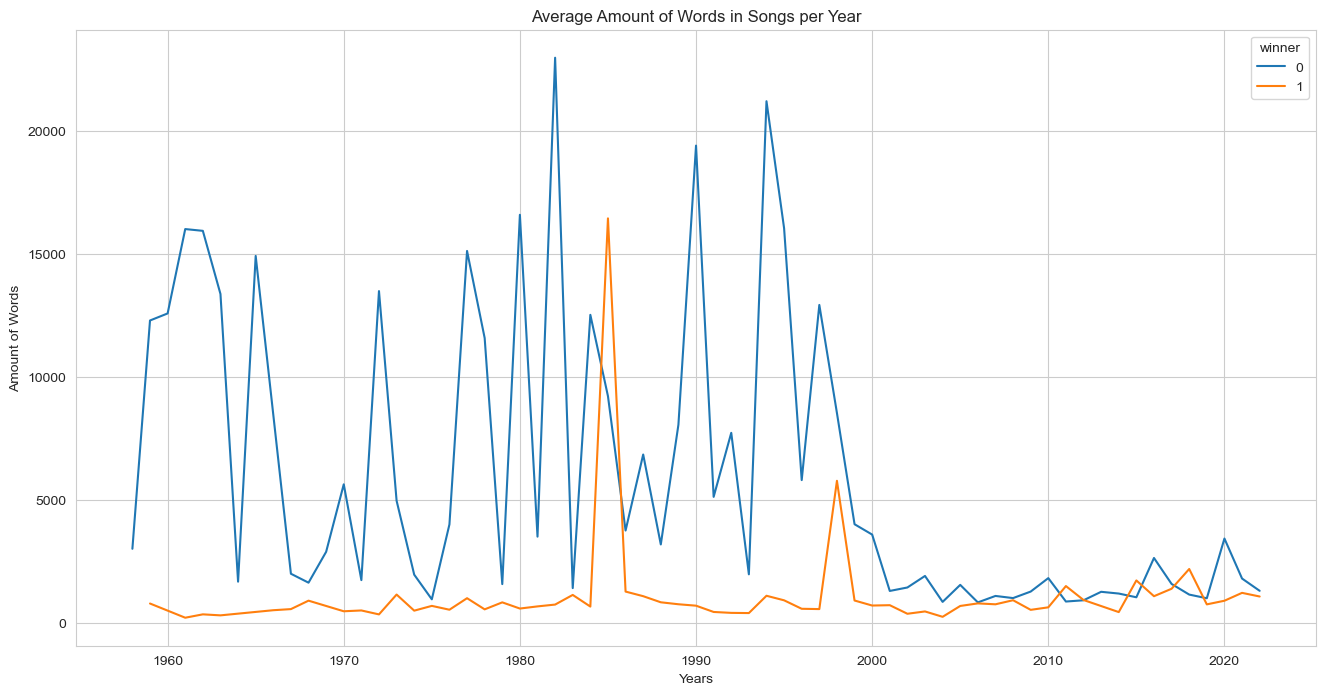

In [68]:
# Plot the average word count for each year
plt.figure(figsize=(16,8))
sns.lineplot(data=analysis_df, x='year', y='word_count', hue='winner', ci=None)
plt.title('Average Amount of Words in Songs per Year')
plt.xlabel('Years')
plt.ylabel('Amount of Words')
plt.show()


In [69]:
def count_unique_words(lst):
    return len(set(lst))

# apply the function to create a new column
analysis_df['unique_word_count'] = analysis_df['preprocessed_lyrics'].apply(lambda x: count_unique_words(x))


/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_19917/85108535.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=analysis_df, x='year', y='unique_word_count', hue='winner', ci=None)


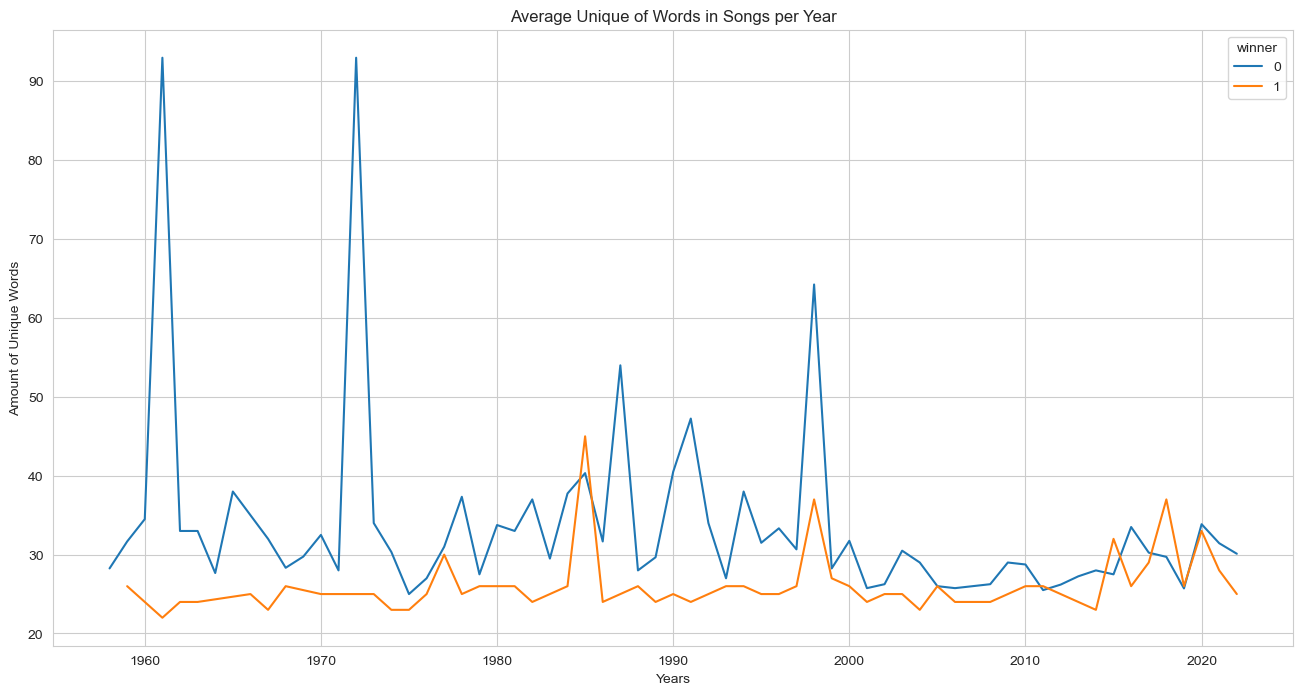

In [70]:
# Plot the average amount of unique words each year
plt.figure(figsize=(16,8))
sns.lineplot(data=analysis_df, x='year', y='unique_word_count', hue='winner', ci=None)
plt.title('Average Unique of Words in Songs per Year')
plt.xlabel('Years')
plt.ylabel('Amount of Unique Words')
plt.show()


Profanity over the decades.

In [71]:
# add decades detail
# Define the decade-to-year range mapping
decade_map = {'50s': (1950, 1960),
              '60s': (1960, 1970),
              '70s': (1970, 1980),
              '80s': (1980, 1990),
              '90s': (1990, 2000),
              '00s': (2000, 2010),
              '10s': (2010, 2020),
              '20s': (2020, 2030)}

# Apply the mapping using the `map()` method
def get_decade(year):
    for key, value in decade_map.items():
        if value[0] <= year < value[1]:
            return key
    return 'unknown'

analysis_df['decade'] = analysis_df['year'].apply(get_decade)

In [72]:
analysis_df.decade

18     60s
157    90s
100    80s
107    80s
85     70s
      ... 
201    00s
39     60s
41     60s
20     60s
14     60s
Name: decade, Length: 284, dtype: object

In [73]:
decades = ['50s', '60s', '70s', '80s', '90s', '00s', '10s', '20s']
common_words = {}

for decade in decades:
    # Filter the DataFrame by decade
    df_decade = analysis_df.loc[analysis_df['decade'] == decade]
    # Join the cleaned lyrics of all songs in the decade
    for i in range(len(df_decade['preprocessed_lyrics'])):
        lyrics = ' '.join(df_decade['preprocessed_lyrics'].iloc[0]).split()
    # Count the occurrences of each word and take the 200 most common words
        common_words[decade] = Counter(lyrics).most_common(200)

commonWords50 = common_words['50s']
commonWords60 = common_words['60s']
commonWords70 = common_words['70s']
commonWords80 = common_words['80s']
commonWords90 = common_words['90s']
commonWords00 = common_words['00s']
commonWords10 = common_words['10s']
commonWords20 = common_words['20s']

https://github.com/coffee-and-fun/google-profanity-words

In [74]:
url  = 'https://raw.githubusercontent.com/coffee-and-fun/google-profanity-words/main/data/list.txt'
google_profanity_words = request.urlopen(url)

profane_words = []
for line in google_profanity_words:
    profane_words.append(line.decode("utf-8").strip())

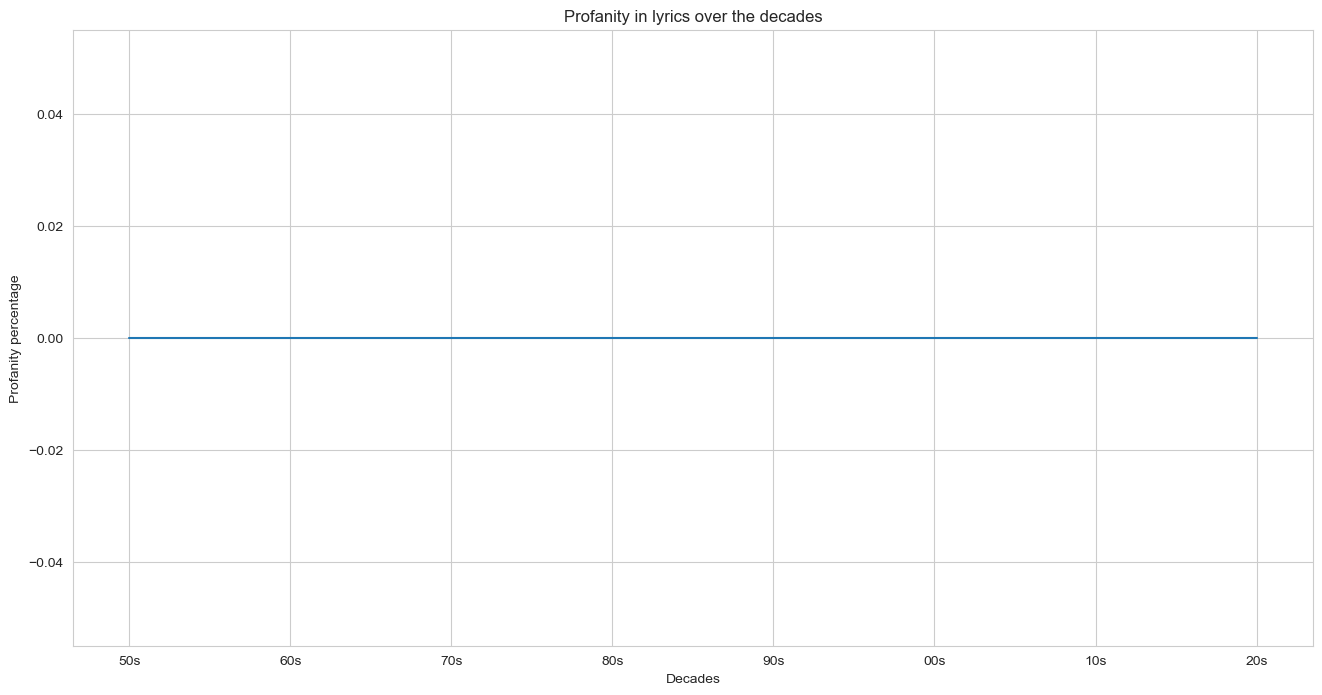

In [75]:
commonWords = [commonWords50, commonWords60, commonWords70, commonWords80, commonWords90, commonWords00, commonWords10, commonWords20]
counts = []
for item in commonWords:
    totalCount = 0
    count = 0
    for key,value in item:
        if key in profane_words:
            count += value
        totalCount += value
    counts.append(count/totalCount * 100)

profanity_dict = {}
for i, decade in enumerate(decades):
    profanity_dict[decade] = counts[i]

profanity_df = pd.DataFrame.from_dict(profanity_dict, orient='index', columns=['Profanity Percentage'])

sns.set_style("whitegrid")
plt.figure(figsize=(16,8))
sns.lineplot(data=profanity_df, x=profanity_df.index, y='Profanity Percentage')
plt.title("Profanity in lyrics over the decades")
plt.xlabel("Decades")
plt.ylabel("Profanity percentage")
plt.show()




Wordcloud.

In [76]:
winner_df = analysis_df[analysis_df.winner==1]
nominee_df = analysis_df[analysis_df.winner==0]

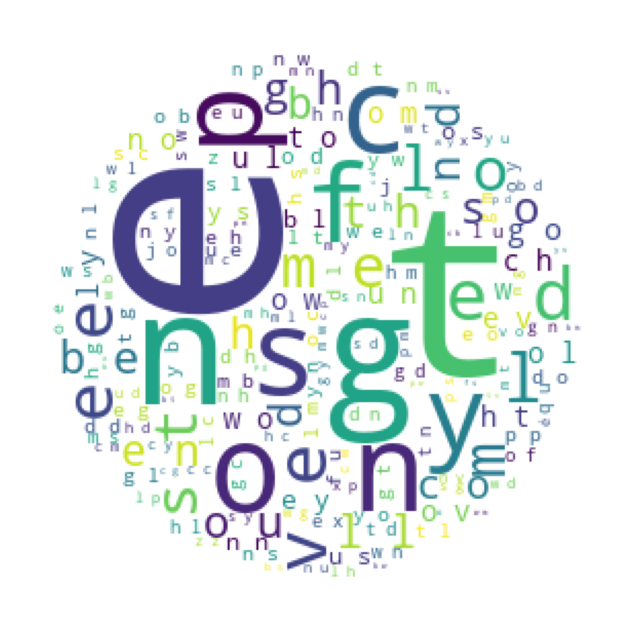

In [77]:
#convert list to string and generate

x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

unique_string = ' '.join(winner_df['preprocessed_lyrics'].sum())
wordcloud = WordCloud(background_color="white",
                      mask=mask,
                      width = 1000,
                      height = 500).generate(unique_string)
plt.figure(figsize=(19,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
plt.close()

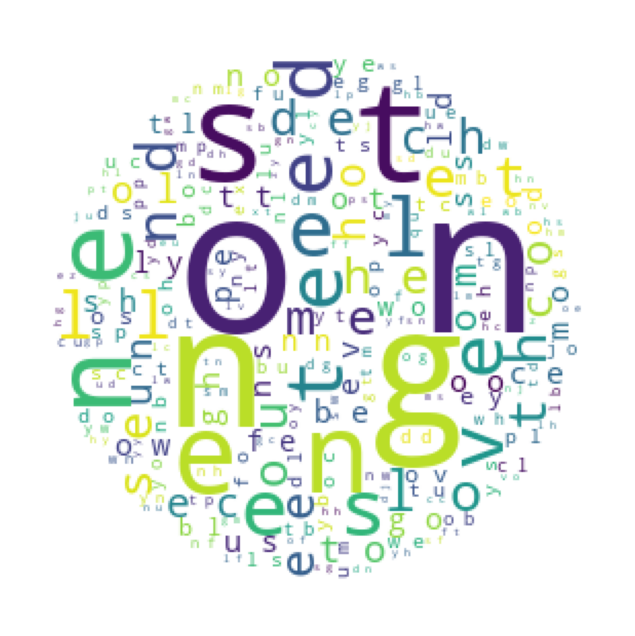

In [78]:
#convert list to string and generate

x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

unique_string = ' '.join(nominee_df['preprocessed_lyrics'].sum())
wordcloud = WordCloud(background_color="white",
                      mask=mask,
                      width = 1000,
                      height = 500).generate(unique_string)
plt.figure(figsize=(19,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
plt.close()

Multiple Grammy winners.
Can you guess who has won more than 1 Grammy Best Record?

In [79]:
dupes = analysis_df[analysis_df.winner==1]
dupes = dupes[dupes['artist'].duplicated(keep=False)]
dupes.sort_values('artist')

,Unnamed: 0,title,artist,winner,year,lyrics,preprocessed_lyrics,language,anger_pct,anticipation_pct,...,negative_pct,positive_pct,sadness_pct,surprise_pct,trust_pct,lyrical_length,gloom_index,word_count,unique_word_count,decade
236,236,Rolling In The Deep,Adele,1,2011,TranslationsFrançaisEspañolPortuguêsΕλληνικάRo...,deep lyric fire starting heart reaching fever ...,en,3.563971,3.379122,...,3.007243,2.862538,2.987029,3.145723,3.447494,281,4.006304,1513,26,10s
262,262,Hello,Adele,1,2016,TranslationsTürkçePortuguêsPortuguêsEspañolHel...,lyric hello wondering year like meet go everyt...,en,0.000000,2.033202,...,4.199852,3.767889,4.199852,2.802342,3.731949,186,3.735347,1101,26,10s
288,288,Everything I Wanted,Billie Eilish,1,2020,TranslationsTürkçeEspañolРусскийRomânăPortuguê...,bokmål riksmål italianobahasa indonesiamagyard...,en,3.516372,3.114200,...,2.912175,3.960228,2.656074,3.516995,4.411212,146,1.857004,917,33,20s
280,280,Bad Guy,Billie Eilish,1,2019,TranslationsHrvatskiTürkçeSvenskaEspañolРусски...,guy lyric white shirt red bloody nose sleepin ...,en,2.543258,3.180026,...,3.187040,2.832331,2.802847,2.476920,2.528817,145,1.946290,769,26,10s
163,163,Change The World,Eric Clapton,1,1996,Change the World Lyrics\nIf I could reach the ...,change world lyric could reach star pull one s...,en,0.000000,2.023863,...,3.068970,2.012628,0.000000,1.856699,2.485711,94,0.000000,590,25,90s
147,147,Tears In Heaven,Eric Clapton,1,1992,Tears in Heaven Lyrics\nWould you know my name...,tear heaven lyric would know name saw heaven w...,en,0.000000,2.031585,...,5.959342,3.394393,0.000000,2.701245,3.394393,73,0.000000,424,25,90s
20,20,Days Of Wine And Roses,Henry Mancini,1,1963,The Days of Wine and Roses LyricsThe days of w...,day wine rose lyricsthe day wine rose laugh ru...,en,2.891289,2.592046,...,2.891289,3.690752,2.891289,3.130182,2.891289,50,0.701321,323,24,60s
14,14,Moon River,Henry Mancini,1,1961,Moon River LyricsMoon River\nWider than a mile...,moon river lyricsmoon river wider mile crossin...,en,0.000000,0.000000,...,0.000000,2.258040,0.000000,0.000000,2.258040,37,0.000000,227,22,60s
63,63,Killing Me Softly With His Song,Roberta Flack,1,1973,Killing Me Softly with His Song Lyrics\nStrumm...,killing softly song lyric strumming pain finge...,en,3.990254,2.439276,...,3.722268,2.567994,3.753074,2.095850,2.585917,192,3.445084,1168,25,70s
59,59,The First Time Ever I Saw Your Face,Roberta Flack,1,1972,The First Time Ever I Saw Your Face Lyrics\nTh...,first time ever saw face lyric first time ever...,en,3.819276,2.128682,...,4.805401,2.786144,3.988400,3.414724,3.147069,66,1.270951,362,25,70s


Gloom Index by year.

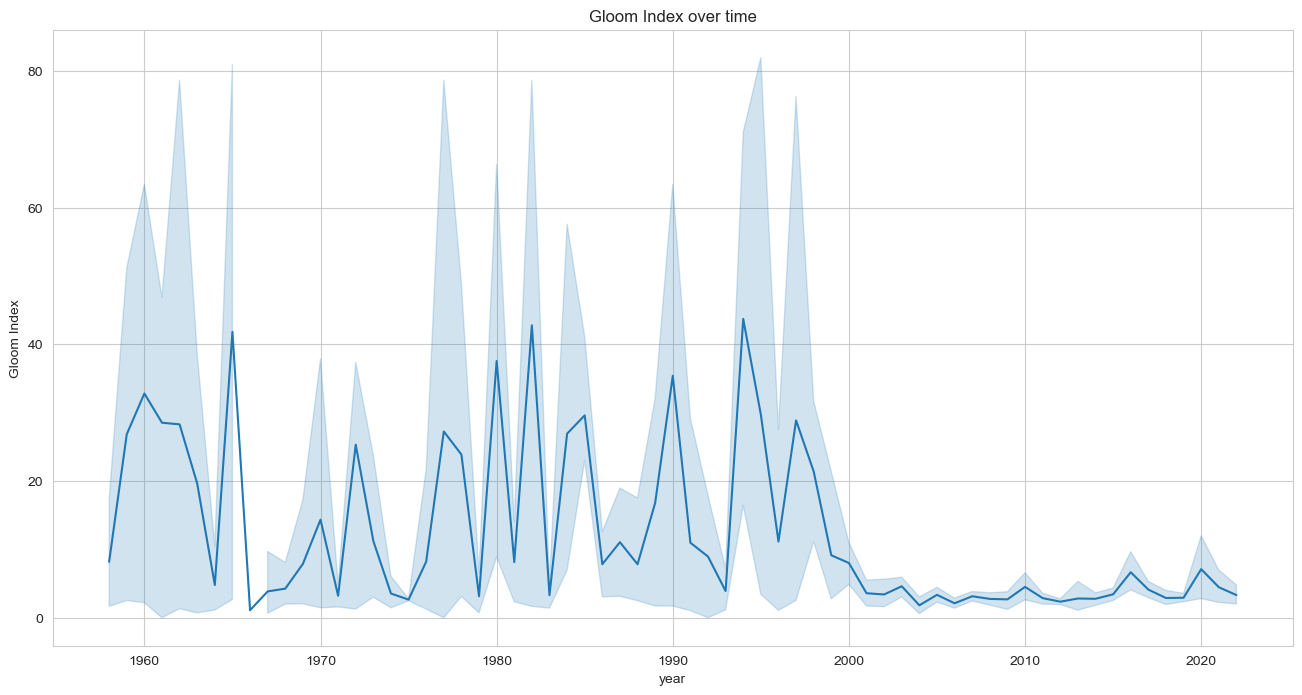

In [80]:
plt.figure(figsize=(16,8))
tg = sns.lineplot(data=analysis_df, x='year', y='gloom_index');
tg.set_ylabel("Gloom Index")
tg.set_title("Gloom Index over time")
plt.show()



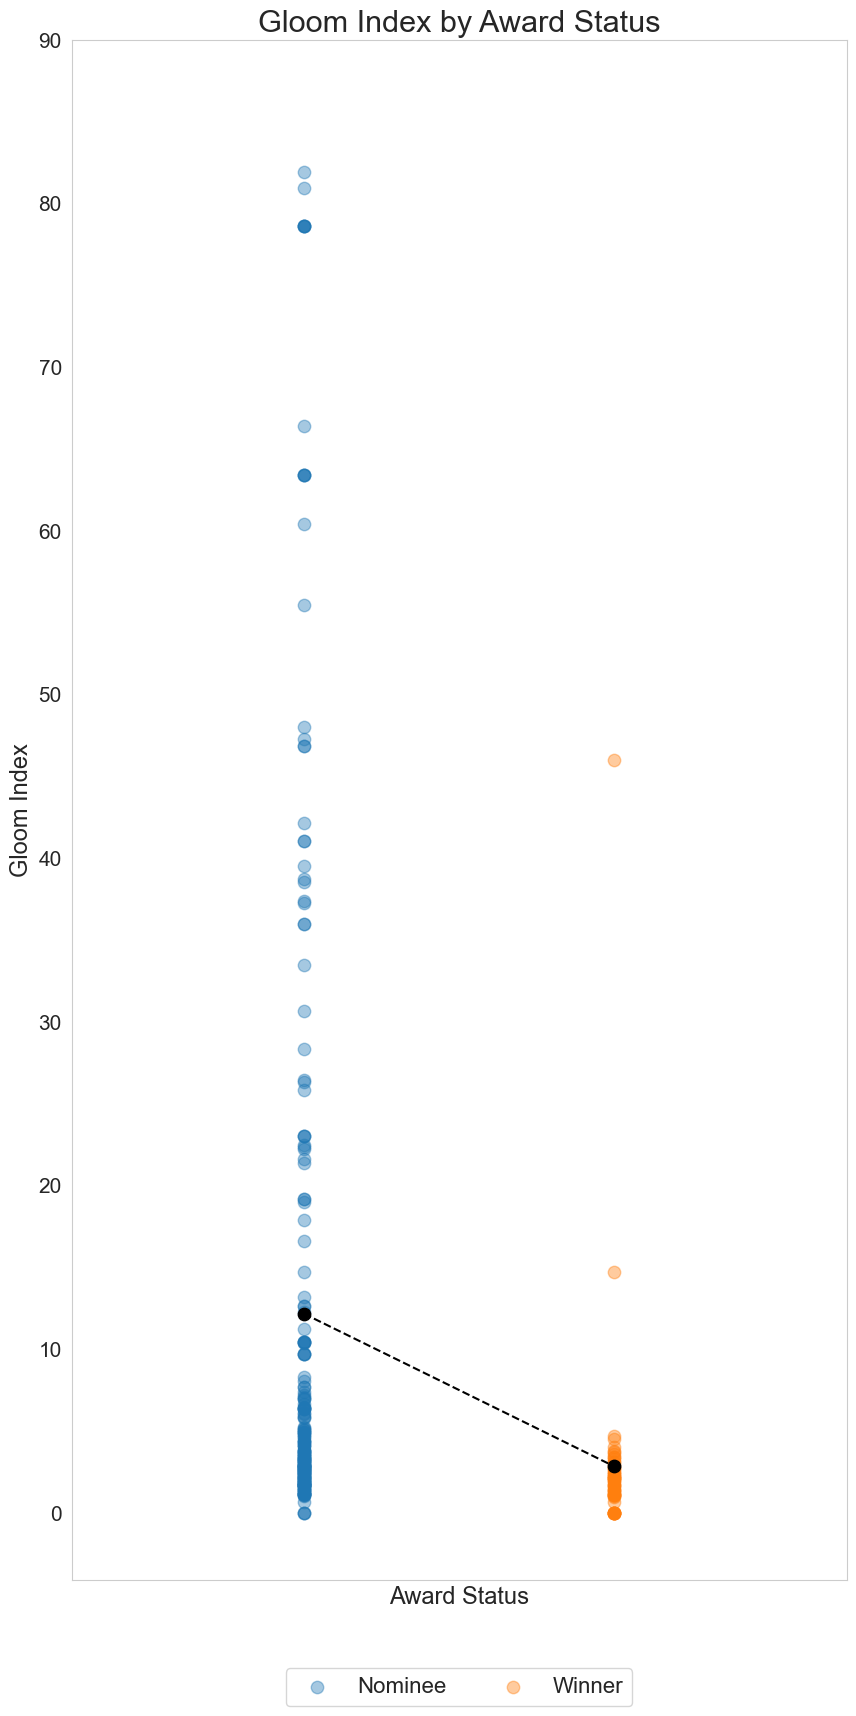

<module 'matplotlib.pyplot' from '/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [81]:
from make_diff_graph import make_diff_graph
from make_time_graph import make_time_graph

make_diff_graph(analysis_df)

<module 'matplotlib.pyplot' from '/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

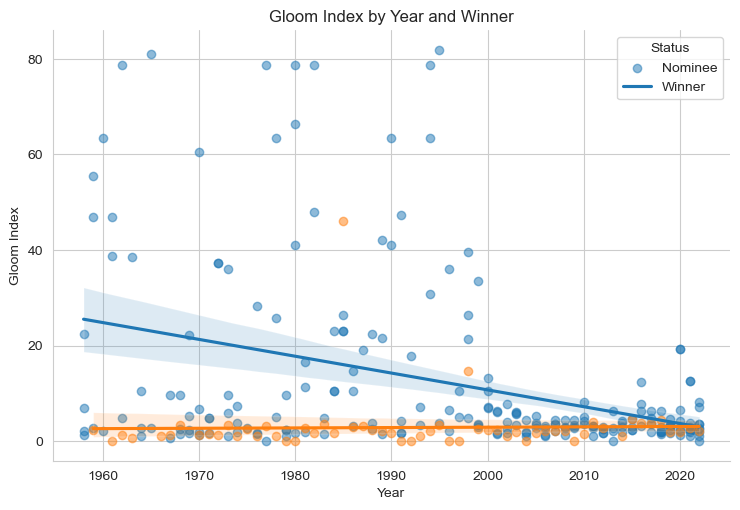

In [82]:
make_time_graph(analysis_df)

*Predictions: correlation between sentiment percentages and Grammy wins* 

/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_19917/1353268167.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(analysis_df.corr(),


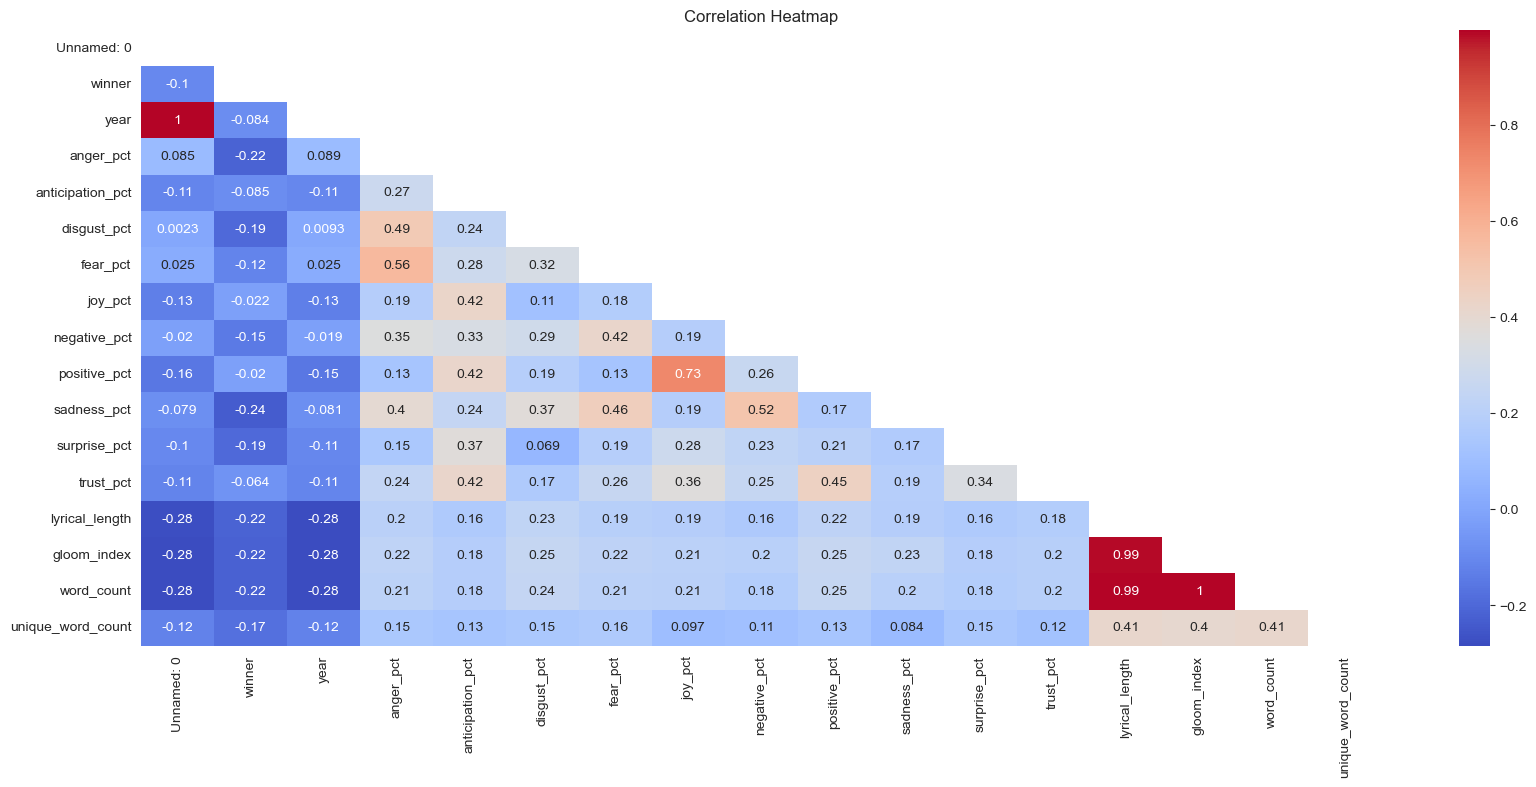

In [83]:
plt.figure(figsize = (20, 8))
mask = np.triu(np.ones_like(analysis_df.corr(numeric_only=True), dtype=bool))
heatmap = sns.heatmap(analysis_df.corr(),
                      mask=mask,
                      annot=True,
                      cmap='coolwarm')
heatmap.set_title('Correlation Heatmap');

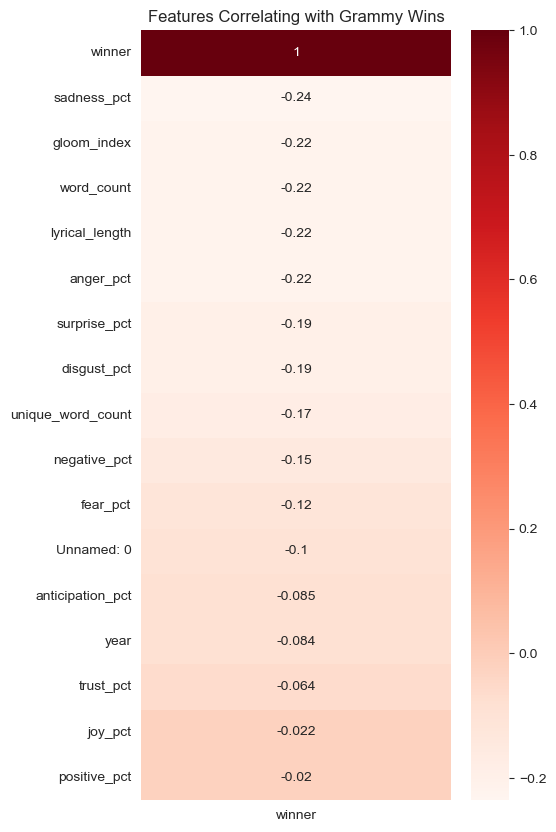

In [84]:
top_features = analysis_df.corr(numeric_only=True)[['winner']].sort_values(by='winner', key = abs, ascending=False)
plt.figure(figsize=(5, 10))
heatmap = sns.heatmap(top_features,
                      annot=True,
                      cmap='Reds')
heatmap.set_title('Features Correlating with Grammy Wins');
plt.yticks(rotation=0);

In [85]:
# split data set 
X = analysis_df.drop(['winner', 'title', 'artist', 'lyrics', 'preprocessed_lyrics', 'language', 'decade'], axis=1) 
y = analysis_df["winner"]  # This is the classification outcome: winner/nominee

# perform training and test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# to print stats
feature_names = X.columns


In [86]:
# import XGBClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


# declare parameters
params = {
            # 'objective':'binary:logistic',
            # 'max_depth': 8,
            # 'alpha': 10,
            # 'learning_rate': 1.0,
            # 'n_estimators':200
            'solver': 'liblinear',
            'multi_class': 'ovr'
        }
            
# lr
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)

# svm
svm_clf = SVC(kernel='linear', C=1)
svm_clf.fit(X_train, y_train)
svm_pred = svm_clf.predict(X_test)

# decision tree
dt_clf = DecisionTreeClassifier(max_depth=2)
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)

# xg boost
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)
xgb_pred = xgb_clf.predict(X_test)

# check accuracy score
print('Logistic Regression model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, lr_pred)))
print('SVM model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, svm_pred)))
print('Decision Tree model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, dt_pred)))
print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, xgb_pred)))

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression model accuracy score: 0.8772
SVM model accuracy score: 0.8596
Decision Tree model accuracy score: 0.8596
XGBoost model accuracy score: 0.8070
